# 02 — Preprocessing Pipeline
**Ensemble Early Parkinson Detection Using Voice Biomarkers**

This notebook builds and validates the preprocessing pipeline:
1. Verifying subject-wise GroupKFold splitting (no data leakage)
2. Demonstrating the data leakage effect (record-wise vs subject-wise CV)
3. Testing StandardScaler inside the pipeline
4. Validating SMOTE integration within training folds only
5. Running initial baseline classifiers with default parameters

## 1. Setup

In [1]:
import sys
sys.path.insert(0, '..')  # so notebooks can import from src/

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold, StratifiedKFold

from src.data_utils import load_parkinsons, get_X_y_groups, FEATURE_COLS
from src.eval_utils import compute_metrics, results_to_dataframe, print_cv_summary, compute_cv_metrics
from src.pipeline_utils import (
    build_pipeline, run_grouped_cv, get_classifiers, run_all_baselines
)

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
sns.set_style('whitegrid')

# Load data
df = load_parkinsons()
X, y, groups = get_X_y_groups(df)
print(f'X: {X.shape}, y: {y.shape}, Subjects: {groups.nunique()}')
print(f'Class distribution: {dict(y.value_counts())}')

X: (195, 22), y: (195,), Subjects: 32
Class distribution: {1: 147, 0: 48}


## 2. Verifying Subject-Wise GroupKFold

We must ensure that **all recordings from one subject stay in the same fold**. Let's verify this explicitly.

In [2]:
gkf = GroupKFold(n_splits=5)

print('GroupKFold — Subject assignments per fold:\n')
for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    train_subjects = set(groups.iloc[train_idx])
    test_subjects = set(groups.iloc[test_idx])
    overlap = train_subjects & test_subjects
    
    print(f'Fold {fold_idx + 1}:')
    print(f'  Train: {len(train_idx)} samples from {len(train_subjects)} subjects')
    print(f'  Test:  {len(test_idx)} samples from {len(test_subjects)} subjects')
    print(f'  Test subjects: {sorted(test_subjects)}')
    print(f'  Subject overlap (should be empty): {overlap}')
    
    # Class distribution in this fold's test set
    test_y = y.iloc[test_idx]
    pd_pct = test_y.mean() * 100
    print(f'  Test class balance: {pd_pct:.1f}% PD, {100-pd_pct:.1f}% Healthy')
    print()

GroupKFold — Subject assignments per fold:

Fold 1:
  Train: 158 samples from 26 subjects
  Test:  37 samples from 6 subjects
  Test subjects: ['S06', 'S17', 'S22', 'S27', 'S31', 'S39']
  Subject overlap (should be empty): set()
  Test class balance: 83.8% PD, 16.2% Healthy

Fold 2:
  Train: 158 samples from 26 subjects
  Test:  37 samples from 6 subjects
  Test subjects: ['S05', 'S16', 'S32', 'S35', 'S42', 'S49']
  Subject overlap (should be empty): set()
  Test class balance: 67.6% PD, 32.4% Healthy

Fold 3:
  Train: 158 samples from 26 subjects
  Test:  37 samples from 6 subjects
  Test subjects: ['S04', 'S08', 'S21', 'S24', 'S33', 'S43']
  Subject overlap (should be empty): set()
  Test class balance: 83.8% PD, 16.2% Healthy

Fold 4:
  Train: 153 samples from 25 subjects
  Test:  42 samples from 7 subjects
  Test subjects: ['S02', 'S10', 'S19', 'S25', 'S34', 'S44', 'S50']
  Subject overlap (should be empty): set()
  Test class balance: 71.4% PD, 28.6% Healthy

Fold 5:
  Train: 153 

## 3. Data Leakage Demonstration

This is a **key finding** for the report. We compare record-wise (standard) CV against subject-wise CV to show how dramatically data leakage inflates results.

With record-wise CV, the same patient's recordings can appear in both train and test sets. The model memorizes individual voice characteristics rather than learning PD biomarkers.

In [3]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
import warnings

# Build a simple SVM pipeline for comparison
svm_pipe = ImbPipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='rbf', probability=True, random_state=42))
])


def run_cv_comparison(pipeline, X, y, groups, n_splits=5):
    """Compare record-wise vs subject-wise CV."""
    results = {}
    
    # 1. Record-wise (LEAKY) — standard StratifiedKFold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    y_trues, y_preds, y_probs = [], [], []
    for train_idx, test_idx in skf.split(X, y):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            pipeline.fit(X_tr, y_tr)
        y_trues.append(y_te.values)
        y_preds.append(pipeline.predict(X_te))
        try:
            y_probs.append(pipeline.predict_proba(X_te)[:, 1])
        except:
            y_probs.append(None)
    
    all_yt = np.concatenate(y_trues)
    all_yp = np.concatenate(y_preds)
    all_yprob = np.concatenate([p for p in y_probs if p is not None]) if y_probs[0] is not None else None
    results['Record-wise CV (LEAKY)'] = compute_metrics(all_yt, all_yp, all_yprob)
    
    # 2. Subject-wise (CORRECT) — GroupKFold
    gkf = GroupKFold(n_splits=n_splits)
    y_trues, y_preds, y_probs = [], [], []
    for train_idx, test_idx in gkf.split(X, y, groups):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            pipeline.fit(X_tr, y_tr)
        y_trues.append(y_te.values)
        y_preds.append(pipeline.predict(X_te))
        try:
            y_probs.append(pipeline.predict_proba(X_te)[:, 1])
        except:
            y_probs.append(None)
    
    all_yt = np.concatenate(y_trues)
    all_yp = np.concatenate(y_preds)
    all_yprob = np.concatenate([p for p in y_probs if p is not None]) if y_probs[0] is not None else None
    results['Subject-wise CV (CORRECT)'] = compute_metrics(all_yt, all_yp, all_yprob)
    
    return results


leakage_results = run_cv_comparison(svm_pipe, X, y, groups)
leakage_df = results_to_dataframe(leakage_results)
leakage_df

,accuracy,balanced_accuracy,sensitivity,specificity,precision,f1,mcc,auc_roc
Model,,,,,,,,
Record-wise CV (LEAKY),0.8718,0.7466,0.9932,0.5000,0.8588,0.9211,0.6355,0.8875
Subject-wise CV (CORRECT),0.7846,0.6327,0.9320,0.3333,0.8107,0.8671,0.3362,0.6359


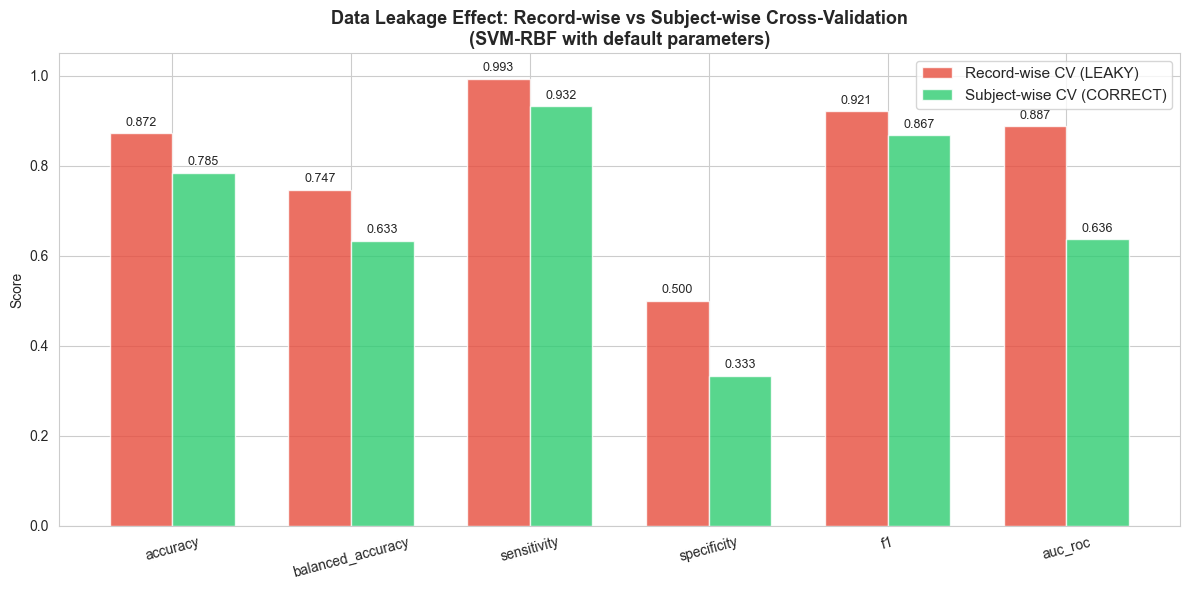


Accuracy drop from leakage correction: 8.7 percentage points


In [4]:
# Visualize the leakage effect
metrics_to_plot = ['accuracy', 'balanced_accuracy', 'sensitivity', 'specificity', 'f1', 'auc_roc']
plot_data = leakage_df[metrics_to_plot].T

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(metrics_to_plot))
width = 0.35

bars1 = ax.bar(x - width/2, plot_data['Record-wise CV (LEAKY)'], width,
               label='Record-wise CV (LEAKY)', color='#e74c3c', alpha=0.8)
bars2 = ax.bar(x + width/2, plot_data['Subject-wise CV (CORRECT)'], width,
               label='Subject-wise CV (CORRECT)', color='#2ecc71', alpha=0.8)

ax.set_ylabel('Score')
ax.set_title('Data Leakage Effect: Record-wise vs Subject-wise Cross-Validation\n(SVM-RBF with default parameters)',
             fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_to_plot, rotation=15)
ax.legend(fontsize=11)
ax.set_ylim(0, 1.05)

# Annotate bars
for bars in [bars1, bars2]:
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.01, f'{h:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../figures/leakage_comparison.png', bbox_inches='tight')
plt.show()

acc_drop = (leakage_df.loc['Record-wise CV (LEAKY)', 'accuracy'] - 
            leakage_df.loc['Subject-wise CV (CORRECT)', 'accuracy']) * 100
print(f'\nAccuracy drop from leakage correction: {acc_drop:.1f} percentage points')

## 4. SMOTE Validation

Verify that SMOTE is applied **only within training folds** and produces the expected resampled counts.

In [5]:
from imblearn.over_sampling import SMOTE

gkf = GroupKFold(n_splits=5)
smote = SMOTE(random_state=42)
scaler = StandardScaler()

print('SMOTE validation — checking resampled class distributions per fold:\n')
for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    
    # Scale first (fit on train only)
    X_train_scaled = scaler.fit_transform(X_train)
    
    # SMOTE on training data only
    X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)
    
    print(f'Fold {fold_idx + 1}:')
    print(f'  Before SMOTE — Train: {len(y_train)} (PD: {(y_train==1).sum()}, Healthy: {(y_train==0).sum()})')
    print(f'  After SMOTE  — Train: {len(y_resampled)} (PD: {(y_resampled==1).sum()}, Healthy: {(y_resampled==0).sum()})')
    print(f'  Test (untouched): {len(y_test)} (PD: {(y_test==1).sum()}, Healthy: {(y_test==0).sum()})')
    print()

SMOTE validation — checking resampled class distributions per fold:

Fold 1:
  Before SMOTE — Train: 158 (PD: 116, Healthy: 42)
  After SMOTE  — Train: 232 (PD: 116, Healthy: 116)
  Test (untouched): 37 (PD: 31, Healthy: 6)

Fold 2:
  Before SMOTE — Train: 158 (PD: 122, Healthy: 36)
  After SMOTE  — Train: 244 (PD: 122, Healthy: 122)
  Test (untouched): 37 (PD: 25, Healthy: 12)

Fold 3:
  Before SMOTE — Train: 158 (PD: 116, Healthy: 42)
  After SMOTE  — Train: 232 (PD: 116, Healthy: 116)
  Test (untouched): 37 (PD: 31, Healthy: 6)

Fold 4:
  Before SMOTE — Train: 153 (PD: 117, Healthy: 36)
  After SMOTE  — Train: 234 (PD: 117, Healthy: 117)
  Test (untouched): 42 (PD: 30, Healthy: 12)

Fold 5:
  Before SMOTE — Train: 153 (PD: 117, Healthy: 36)
  After SMOTE  — Train: 234 (PD: 117, Healthy: 117)
  Test (untouched): 42 (PD: 30, Healthy: 12)



## 5. Baseline Models (Default Parameters)

Run all 6 classifiers with **default parameters**, **no SMOTE**, **no class weighting** — establishing a pure baseline using subject-wise GroupKFold.

In [6]:
print('Running baseline models (no balancing, default params)...\n')
baseline_results = run_all_baselines(X, y, groups, n_splits=5)

# Collect mean metrics into a comparison table
baseline_summary = {name: res['mean_metrics'] for name, res in baseline_results.items()}
baseline_df = results_to_dataframe(baseline_summary)
print('\n--- Baseline Results (Subject-wise 5-fold GroupKFold, no balancing) ---\n')
baseline_df

Running baseline models (no balancing, default params)...

  Running SVM_RBF...
  Running SVM_Linear...
  Running KNN...
  Running Random_Forest...
  Running Logistic_L1...
  Running Logistic_L2...

--- Baseline Results (Subject-wise 5-fold GroupKFold, no balancing) ---



,accuracy,balanced_accuracy,sensitivity,specificity,precision,f1,mcc,auc_roc
Model,,,,,,,,
SVM_RBF,0.7903,0.6418,0.9335,0.3500,0.8153,0.8665,0.3041,0.6078
SVM_Linear,0.7722,0.6474,0.8948,0.4000,0.8252,0.8505,0.3352,0.6875
KNN,0.7512,0.6086,0.8840,0.3333,0.8073,0.8404,0.2160,0.7529
Random_Forest,0.8040,0.6753,0.9340,0.4167,0.8316,0.8765,0.3662,0.8333
Logistic_L1,0.7906,0.6879,0.8924,0.4833,0.8477,0.8639,0.3790,0.7425
Logistic_L2,0.7906,0.6886,0.8939,0.4833,0.8479,0.8640,0.3847,0.7500


In [7]:
# Also show std for key metrics
baseline_std = {name: res['std_metrics'] for name, res in baseline_results.items()}
baseline_std_df = results_to_dataframe(baseline_std)

print('--- Standard Deviations Across Folds ---\n')
baseline_std_df

--- Standard Deviations Across Folds ---



,accuracy,balanced_accuracy,sensitivity,specificity,precision,f1,mcc,auc_roc
Model,,,,,,,,
SVM_RBF,0.1091,0.1617,0.1012,0.3180,0.0867,0.0760,0.3835,0.3209
SVM_Linear,0.0676,0.1026,0.1309,0.2759,0.0716,0.0597,0.2100,0.1875
KNN,0.0531,0.1046,0.0685,0.2528,0.0709,0.0436,0.2012,0.0987
Random_Forest,0.0808,0.1668,0.0559,0.3416,0.0900,0.0539,0.3171,0.1132
Logistic_L1,0.0330,0.1384,0.0776,0.3266,0.0779,0.0286,0.2560,0.1738
Logistic_L2,0.0413,0.1355,0.0900,0.3180,0.0768,0.0330,0.2677,0.1519


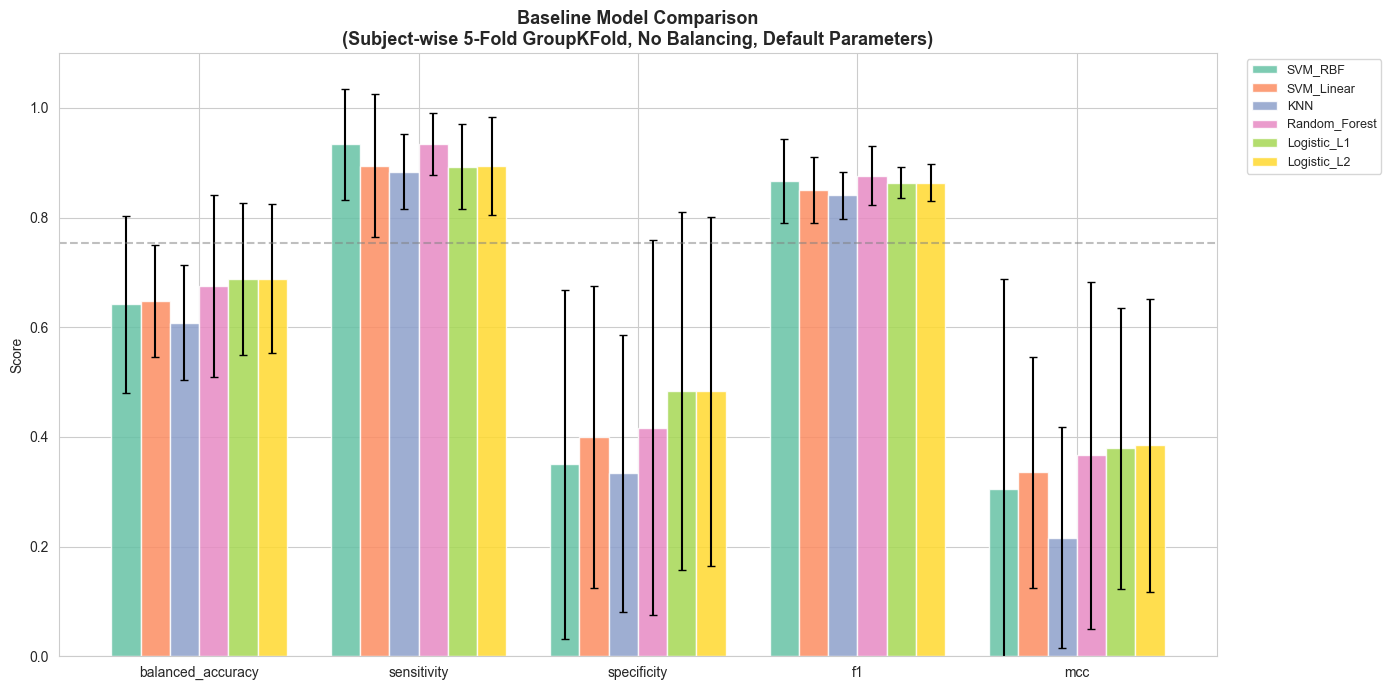

In [8]:
# Visualize baseline comparison
metrics_to_plot = ['balanced_accuracy', 'sensitivity', 'specificity', 'f1', 'mcc']

fig, ax = plt.subplots(figsize=(14, 7))
x = np.arange(len(metrics_to_plot))
n_models = len(baseline_df)
width = 0.8 / n_models

colors = sns.color_palette('Set2', n_models)

for i, (model_name, row) in enumerate(baseline_df.iterrows()):
    vals = [row[m] for m in metrics_to_plot]
    stds = [baseline_std_df.loc[model_name, m] for m in metrics_to_plot]
    ax.bar(x + i * width, vals, width, label=model_name, color=colors[i],
           yerr=stds, capsize=3, alpha=0.85)

ax.set_ylabel('Score')
ax.set_title('Baseline Model Comparison\n(Subject-wise 5-Fold GroupKFold, No Balancing, Default Parameters)',
             fontsize=13, fontweight='bold')
ax.set_xticks(x + width * (n_models - 1) / 2)
ax.set_xticklabels(metrics_to_plot)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
ax.set_ylim(0, 1.1)
ax.axhline(y=0.754, color='gray', linestyle='--', alpha=0.5, label='Naive baseline (75.4%)')

plt.tight_layout()
plt.savefig('../figures/baseline_comparison.png', bbox_inches='tight')
plt.show()

In [9]:
# Save baseline results for later comparison
baseline_df.to_csv('../results/baseline_results.csv')
baseline_std_df.to_csv('../results/baseline_results_std.csv')
print('Baseline results saved to results/')

Baseline results saved to results/


In [10]:
print(baseline_df.to_string())
print('\n--- Standard Deviations ---')
print(baseline_std_df.to_string())

               accuracy  balanced_accuracy  sensitivity  specificity  precision      f1     mcc  auc_roc
Model                                                                                                   
SVM_RBF          0.7903             0.6418       0.9335       0.3500     0.8153  0.8665  0.3041   0.6078
SVM_Linear       0.7722             0.6474       0.8948       0.4000     0.8252  0.8505  0.3352   0.6875
KNN              0.7512             0.6086       0.8840       0.3333     0.8073  0.8404  0.2160   0.7529
Random_Forest    0.8040             0.6753       0.9340       0.4167     0.8316  0.8765  0.3662   0.8333
Logistic_L1      0.7906             0.6879       0.8924       0.4833     0.8477  0.8639  0.3790   0.7425
Logistic_L2      0.7906             0.6886       0.8939       0.4833     0.8479  0.8640  0.3847   0.7500

--- Standard Deviations ---
               accuracy  balanced_accuracy  sensitivity  specificity  precision      f1     mcc  auc_roc
Model                     

## 6. Key Takeaways

Fill in after running:

1. **Data leakage effect**: Record-wise CV accuracy = ___% vs Subject-wise CV accuracy = ___% → a ___% drop confirming the leakage problem described by Tougui et al.
2. **GroupKFold verification**: No subject overlap between train/test folds confirmed. Fold sizes vary since subjects have different recording counts.
3. **SMOTE validation**: Resampling occurs only within training folds. Test sets remain at their natural class distribution.
4. **Best baseline model**: ___ with balanced accuracy of ___
5. **Worst baseline model**: ___ with balanced accuracy of ___
6. **Sensitivity concern**: Models with high accuracy but low sensitivity may just be predicting majority class (PD)

**Next step**: Notebook 03 — Baseline models with class balancing strategies